# 1. Описание задачи классификации

При создании карточки товара селлеру нужно указать его тип, который обычно похож на название. Для одного товара может подойти несколько типов. Иногда селлеры ошибаются в указании типа товара или делают это намеренно, чтобы снизить комиссию.

Нужно создать список типов, например из десяти доступных, из которого селлер выберет подходящий.


Задача — бинарная классификация:

предсказать, правильно ли указан type товара продавцом или нет
- target = 1 — категория (type) указана верно
- target = 0 — категория указана неверно



Метрики — ROC-AUC. Нужна ранжируемость.

Данные: список всех доступных типов, картинки, название, описание.

Ограничений по архитектуре нет.

## 2. Знакомство с данными, базовый анализ

In [ ]:
#!pip install lazypredict
!pip install sweetviz ydata-profiling
!pip install pycaret[full]
!pip install optuna
!pip install natasha


## Библиотеки
Первым этапом анализа данных и тренировки модели является импортирование нужных библиотек.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
import sweetviz as sv

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics

from pycaret.classification import *

from pymorphy2 import MorphAnalyzer
from natasha import MorphVocab
import re
from nltk.corpus import stopwords
import re

import lightgbm as lgb

import nltk
nltk.download('stopwords')


pd.set_option('display.max_colwidth', None)  # Показывать всю строку без ограничения длины
pd.set_option('display.max_rows', 15)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Чтение исходных данных
Прочитаем исходные данные

In [ ]:
# Загрузка данных из файлов parquet
data_test = pd.read_parquet('hackaton_test_types_recom.parquet')
data_train = pd.read_parquet('hackaton_train_types_recom.parquet')
print(f'data_train: {data_train.shape}')
print(f'data_test: {data_test.shape}')

# Вывод первых нескольких строк каждого датафрейма для ознакомления
print("Тренировочные данные:")
display(data_train.head())
print("\nТестовые данные:")
display(data_test.head())

data_train: (763013, 8)
data_test: (190754, 8)
Тренировочные данные:


,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/6564759805.jpg,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-06/MATRIX 1.6 01-08/KIA RIO 1.4 05-11/CERATO 1.6 04-06,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/6700269015.jpg,"Масло оливковое Urzante Light рафинированное, с добавлением оливкового нерафинированного, 250 мл",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/7000802343.jpg,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/7120280262.jpg,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0



Тестовые данные:


,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
7809846,https://cdn1.ozone.ru/s3/multimedia-t/6332711633.jpg,"Защитный кейс (бокс, чехол) для карт памяти SD, MicroSD",Комплект фотоаксессуаров,None,None,False,1,nan_False_1
97704,https://cdn1.ozone.ru/s3/multimedia-1-h/7144453493.jpg,"Кружка латте керамическая большая для чая и кофе с прикольным принтом ""Осень посудина с угощениями на пикнике среди яркой листвы"" 480 мл.",Кружка,Дом и сад,Кружка,False,1,Дом и сад_False_1
446046,https://cdn1.ozone.ru/s3/multimedia-1-q/7195946930.jpg,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из нержавеющей стали прессовой (2шт.)",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,True,1,Строительство и ремонт_True_1
511281,https://cdn1.ozone.ru/s3/multimedia-1-w/7228276088.jpg,"Интерьерная картина ""Кирпичи в руинах древней цивилизации"" на холсте 240х90 см. с подвесами",Картина,Дом и сад,Картина,False,1,Дом и сад_False_1
50527,https://cdn1.ozone.ru/s3/multimedia-1-3/6969923031.jpg,"Ножницы Волна , 9"", 23 см, шаг - 18 мм, цвет чёрный",Пирог,Хобби и творчество,Набор для шитья одежды,True,0,Хобби и творчество_True_0


#3. Разведывательный анализ данных (EDA)

In [ ]:
# Вывод информации о тренировочном датафрейме
print("Информация о тренировочном датафрейме:")
data_train.info()

print("\n" + "="*50 + "\n")

# Вывод информации о тестовом датафрейме
print("Информация о тестовом датафрейме:")
data_test.info()

Информация о тренировочном датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 763013 entries, 6762112 to 724995
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       763013 non-null  object
 1   name             763013 non-null  object
 2   type             763013 non-null  object
 3   category_l2      442407 non-null  object
 4   category_l4      442407 non-null  object
 5   is_markup        763013 non-null  bool  
 6   target           763013 non-null  int64 
 7   stratify_column  763013 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 47.3+ MB


Информация о тестовом датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 190754 entries, 7809846 to 6192728
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   main_photo       190754 non-null  object
 1   name             190754 non-null  objec

Исследуем распределение целевой переменной

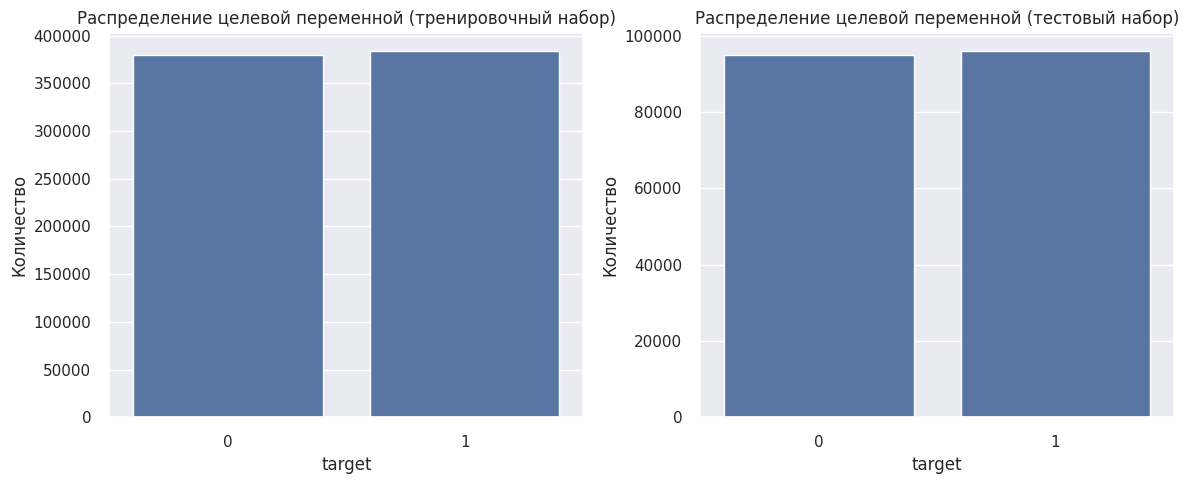

In [ ]:
# Установка стиля для графиков
sns.set(style="darkgrid")

# Создание фигуры с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График для тренировочного набора
sns.countplot(x='target', data=data_train, ax=axes[0])
axes[0].set_title('Распределение целевой переменной (тренировочный набор)')
axes[0].set_xlabel('target')
axes[0].set_ylabel('Количество')

# График для тестового набора
sns.countplot(x='target', data=data_test, ax=axes[1])
axes[1].set_title('Распределение целевой переменной (тестовый набор)')
axes[1].set_xlabel('target')
axes[1].set_ylabel('Количество')

# Отображение графиков
plt.tight_layout()
plt.show()

Распределение равномерное, классы сбалансированы.

Анализ 'category_l2':
Количество уникальных значений в тренировочном наборе: 28
Количество уникальных значений в тестовом наборе: 28

Анализ 'category_l4':
Количество уникальных значений в тренировочном наборе: 3381
Количество уникальных значений в тестовом наборе: 3066


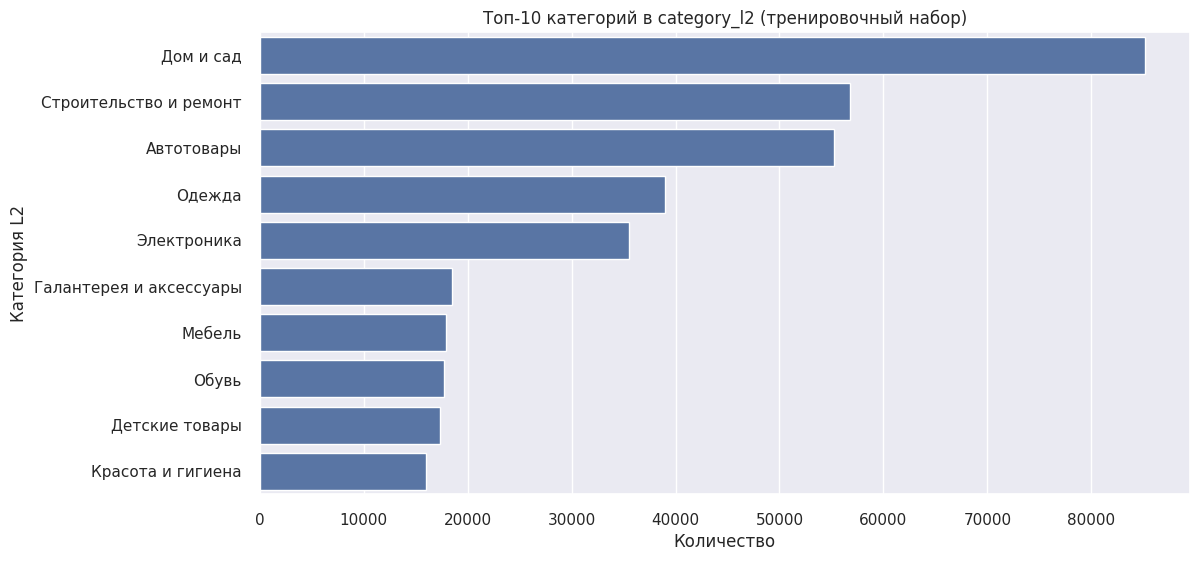

In [ ]:
# Анализ 'category_l2'
print("Анализ 'category_l2':")
print("Количество уникальных значений в тренировочном наборе:", data_train['category_l2'].nunique())
print("Количество уникальных значений в тестовом наборе:", data_test['category_l2'].nunique())

# Анализ 'category_l4'
print("\nАнализ 'category_l4':")
print("Количество уникальных значений в тренировочном наборе:", data_train['category_l4'].nunique())
print("Количество уникальных значений в тестовом наборе:", data_test['category_l4'].nunique())

# Визуализация топ-10 категорий в 'category_l2'
plt.figure(figsize=(12, 6))
category_counts = data_train['category_l2'].value_counts().nlargest(10).reset_index()
category_counts.columns = ['category_l2', 'count']
sns.barplot(x='count', y='category_l2', data=category_counts)
plt.title('Топ-10 категорий в category_l2 (тренировочный набор)')
plt.xlabel('Количество')
plt.ylabel('Категория L2')
plt.show()

Анализ столбца 'name':
Количество пропущенных значений: 0
Количество уникальных значений: 489529


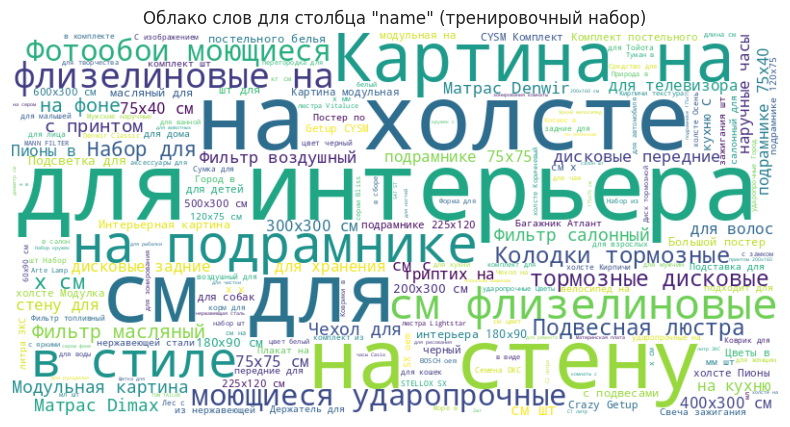


Анализ столбца 'type':
Количество пропущенных значений: 0
Количество уникальных значений: 19981


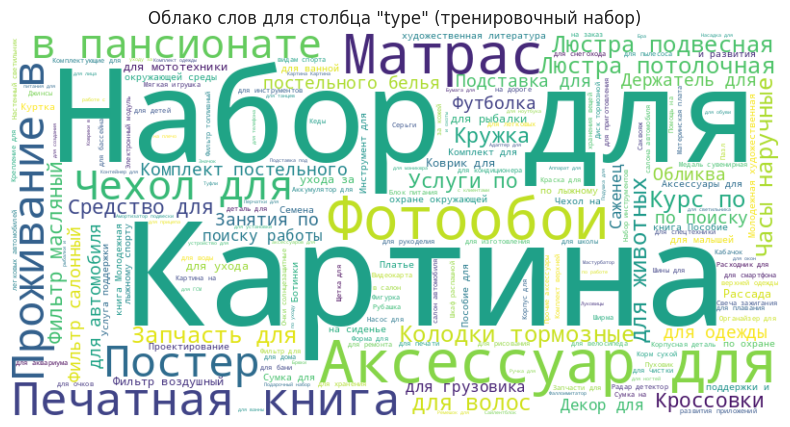

In [ ]:
# Анализ столбца 'name'
print("Анализ столбца 'name':")
print("Количество пропущенных значений:", data_train['name'].isnull().sum())
print("Количество уникальных значений:", data_train['name'].nunique())

# Создание облака слов для 'name'
text = ' '.join(data_train['name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для столбца "name" (тренировочный набор)')
plt.show()

# Анализ столбца 'type'
print("\nАнализ столбца 'type':")
print("Количество пропущенных значений:", data_train['type'].isnull().sum())
print("Количество уникальных значений:", data_train['type'].nunique())

# Создание облака слов для 'type'
text = ' '.join(data_train['type'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для столбца "type" (тренировочный набор)')
plt.show()

Для более тщательного анализа используем пакеты SmartViz и ydata-profiling

In [ ]:
# Анализ тренировочного набора данных
train_report = sv.analyze(data_train)
train_report.show_html('smartviz_train_report.html')

# Анализ тестового набора данных
test_report = sv.analyze(data_test)
test_report.show_html('smartviz_test_report.html')

# Сравнение тренировочного и тестового наборов данных
comparison_report = sv.compare([data_train, "Train"], [data_test, "Test"])
comparison_report.show_html('smartviz_comparison_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report smartviz_train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report smartviz_test_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report smartviz_comparison_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# Анализ тренировочного набора данных
train_profile = ProfileReport(data_train, title="Ydata Profiling Report for Train Data")
train_profile.to_file("ydata_train_profile.html")

# Анализ тестового набора данных
test_profile = ProfileReport(data_test, title="Ydata Profiling Report for Test Data")
test_profile.to_file("ydata_test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:34<00:00,  4.31s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Выводы по результатам разведочного анализа данных (EDA)

На основе проведенного анализа  можно сделать следующие выводы:

1. Общая характеристика данных:

    - Обучающий набор (train_df): Содержит 763 013 записей и 8 столбцов.
    - Тестовый набор (test_df): Содержит 190 754 записи и 8 столбцов.

2. Анализ признаков:

    - main_photo: Содержит URL-адреса изображений. В обоих наборах данных есть пропущенные значения.
    - name: Название товара. В обоих наборах данных есть пропущенные значения.
    - type: Тип товара. В обоих наборах данных есть пропущенные значения.
    - category_l2: Категория 2-го уровня. В обоих наборах данных есть пропущенные значения.
    - category_l4: Категория 4-го уровня. В обоих наборах данных есть пропущенные значения.
    - is_markup: Булевый признак, скорее всего, указывающий на наличие разметки. В обоих наборах данных есть пропущенные значения.
    - target: Целевая переменная. В обоих наборах данных есть пропущенные значения.
    - stratify_column: Столбец для стратификации. В обоих наборах данных есть пропущенные значения.

3. Сравнение обучающего и тестового наборов:

    - Распределение признаков: Распределения признаков в обучающем и тестовом наборах данных в целом схожи.
    - Пропущенные значения: В обоих наборах данных наблюдается значительное количество пропущенных значений в столбцах category_l2 и category_l4. Это может потребовать дополнительной обработки данных перед построением модели.
    - Повторящиеся строки: в обоих наборах есть дубликаты, от них надо избавиться.

4. Рекомендации:

    - Обработка пропущенных значений: Необходимо разработать стратегию для обработки пропущенных значений в столбцах category_l2 и category_l4.
    - Возможные варианты:
        Заполнение пропущенных значений наиболее частым значением.
        Создание отдельной категории для пропущенных значений.
        Использование моделей, которые могут обрабатывать пропущенные значения.
    - Создание новых признаков: Можно попробовать создать новые признаки на основе существующих, например, извлечь информацию из URL-адресов изображений или из названий товаров.
    - Выбор модели: Учитывая наличие как категориальных, так и текстовых данных, можно рассмотреть использование моделей, таких как градиентный бустинг (например, LightGBM или CatBoost) или нейронные сети.


#4. Подготовка данных


## Проверка на отсутствующие значения

In [ ]:
# Функция для удаления пропусков / аномалий
def remove__missing(df, column, errors):
    cleaned = df[column].astype(str).str.strip().str.lower()
    return df[~cleaned.isin(errors)].reset_index(drop=True)
# # Функция для замены пропусков / аномалий на 'unknown'
def replace__missing(df, column, errors):
    df[column] = df[column].astype(str).str.strip().str.lower().apply(lambda x: '' if x in errors else x)
    return df


# Применение:
# errors = ['0', '1', 'unknown', 'none', 'null', 'nan', 'n/a', 'na', 'missing', '?', ' ', '-', '', '...', 'неизвестно']
# before_train, before_test = data_train.shape[0], data_test.shape[0]
# for category in ['name', 'type', 'category_l2', 'category_l4']:
#     data_train = remove__missing(data_train, category, errors)
#     data_test = remove__missing(data_test, category, errors)
# print(f'data_train: {data_train.shape} - теряем {((before_train - data_train.shape[0]) / before_train) * 100:.2f}% информации')
# print(f'data_test:  {data_test.shape} - теряем {((before_test - data_test.shape[0]) / before_test) * 100:.2f}% информации')

# Применение:
errors = ['0', '1', 'unknown', 'none', 'null', 'nan', 'n/a', 'na', 'missing', '?', ' ', '-', '', '...', 'неизвестно']
for category in ['name', 'type', 'category_l2', 'category_l4']:
    data_train = replace__missing(data_train, category, errors)
    data_test = replace__missing(data_test, category, errors)
print(f'data_train: {data_train.shape}')
print(f'data_test:  {data_test.shape}')

data_train: (763013, 8)
data_test:  (190754, 8)


### Поиск и удаление дубликатов

In [ ]:
# Проверяем наличие дублирующихся строк в обучающих данных
print(f"Количество дублирующихся строк в обучающих данных: {data_train.duplicated().sum()}")

# Проверяем наличие дублирующихся строк в тестовых данных
print(f"Количество дублирующихся строк в тестовых данных: {data_test.duplicated().sum()}")

# Удаляем дублирующиеся строки
data_train.drop_duplicates(inplace=True)
data_test.drop_duplicates(inplace=True)

print("\nДублирующиеся строки были удалены.")

# Проверяем, что дубликаты были удалены
print(f"Количество дублирующихся строк в обучающих данных после удаления: {data_train.duplicated().sum()}")
print(f"Количество дублирующихся строк в тестовых данных после удаления: {data_test.duplicated().sum()}")

Количество дублирующихся строк в обучающих данных: 47734
Количество дублирующихся строк в тестовых данных: 5224

Дублирующиеся строки были удалены.
Количество дублирующихся строк в обучающих данных после удаления: 0
Количество дублирующихся строк в тестовых данных после удаления: 0


In [ ]:
print(f'data_train: {data_train.shape}')
print(f'data_test:  {data_test.shape}')

data_train: (715279, 8)
data_test:  (185530, 8)


### Удаление "лишних" данных

- Данные в колонке 'stratify_column' являются комбинацией  category_l4, is_markup, target, поэтому этот столбец можно удалить.

- Обработка признаков из изображений  требует слишком много аппаратных и временных ресурсов, поэтому убираем 'main_photo'

- Убираем 'category_l2','category_l4','is_markup' , так как непонятно их происхождение. Будем предполгать, что  доступны тольео изображение и описание предмета.  


In [ ]:
data_test = data_test.drop(labels=['main_photo','category_l2','category_l4','is_markup', 'stratify_column'], axis=1).reset_index(drop=True)
data_train = data_train.drop(labels=['main_photo','category_l2','category_l4','is_markup', 'stratify_column'], axis=1).reset_index(drop=True)
print(f'data_train: {data_train.shape}')
print(f'data_test: {data_test.shape}')

data_train: (715279, 3)
data_test: (185530, 3)


In [ ]:
# data_train['is_markup'] = data_train['is_markup'].astype(int)
# data_test['is_markup'] = data_test['is_markup'].astype(int)

In [ ]:
# Заполнение пропущенных значений
# data_train['category_l2'].fillna('Отсутствует', inplace=True)
# data_test['category_l2'].fillna('Отсутствует', inplace=True)
# data_train['category_l4'].fillna('Отсутствует', inplace=True)
# data_test['category_l4'].fillna('Отсутствует', inplace=True)

### Добавление новых признаков

Объединеним столбцы name и type в единый текстовый признак — это распространенная и эффективная стратегия в машинном обучении для такого типа задач. Вот обоснование этого подхода:

- Предоставление полного контекста: Цель модели — определить, является ли type подходящей классификацией для name продукта. Объединяя их, мы предоставляем модели полный контекст в одном входе. Модель может изучить взаимосвязь между словами в названии продукта и словами в присвоенном ему типе.

- Улавливание взаимосвязей между словами: Текстовый векторизатор, такой как TF-IDF, может анализировать объединенный текст для выявления слов и фраз из name, которые часто встречаются вместе со словами и фразами в правильном type.
        
    Пример: Для продукта с названием "Apple iPhone 15 Pro" и типом "Смартфон", объединенный текст будет "Apple iPhone 15 Pro Смартфон". Модель узнает, что совместное появление "iPhone" и "Смартфон" является сильным индикатором правильной классификации (target=1).      
    Если бы типом был "Тостер", текст "Apple iPhone 15 Pro Тостер" был бы очень необычным по сравнению с обучающими данными, что сигнализировало бы о неверной классификации (target=0).

- Создание более информативных признаков: Рассмотрение их как одного признака позволяет TfidfVectorizer (особенно с ngram_range=(1, 2)) создавать признаки из пар слов, которые пересекают границу между name и type. Это позволяет улавливать более тонкие взаимосвязи, чем если бы они обрабатывались отдельно.

Короче говоря, объединение этих столбцов помогает модели лучше понять взаимосвязь между описанием продукта и его типом,

In [ ]:
# Подсчет количества уникальных слов в столбце 'name' обучающего набора данных
unique_words_train_name = data_train['name'].str.split(expand=True).stack().nunique()
print(f"Количество уникальных слов в столбце 'name' обучающего набора данных: {unique_words_train_name}")

# Подсчет количества уникальных слов в столбце 'type' обучающего набора данных
unique_words_train_type = data_train['type'].str.split(expand=True).stack().nunique()
print(f"Количество уникальных слов в столбце 'type' обучающего набора данных: {unique_words_train_type}")

# Подсчет количества уникальных слов в столбце 'name' тестового набора данных
unique_words_test_name = data_test['name'].str.split(expand=True).stack().nunique()
print(f"Количество уникальных слов в столбце 'name' тестового набора данных: {unique_words_test_name}")

# Подсчет количества уникальных слов в столбце 'type' тестового набора данных
unique_words_test_type = data_test['type'].str.split(expand=True).stack().nunique()
print(f"Количество уникальных слов в столбце 'type' тестового набора данных: {unique_words_test_type}")

Количество уникальных слов в столбце 'name' обучающего набора данных: 503371
Количество уникальных слов в столбце 'type' обучающего набора данных: 13488
Количество уникальных слов в столбце 'name' тестового набора данных: 227023
Количество уникальных слов в столбце 'type' тестового набора данных: 12554


In [ ]:
# Инициализация морфологического словаря Natasha
morph_vocab = MorphVocab()

def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    # Очистка текста: удаление знаков препинания, приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    lemmas = []
    for word in words:
        # Получаем все возможные разборы и берем первый
        parsed = morph_vocab.parse(word)
        if parsed:  # Если существует какой-либо анализ
            lemma = parsed[0].normal_form
            lemmas.append(lemma)
        else:
            lemmas.append(word)  # Возвращаемся к исходному слову
    return ' '.join(lemmas)

# Применение лемматизации
print("Применение лемматизации...")
data_train['name_lemmatized'] = data_train['name'].apply(lemmatize_text)
data_train['type_lemmatized'] = data_train['type'].apply(lemmatize_text)
data_test['name_lemmatized'] = data_test['name'].apply(lemmatize_text)
data_test['type_lemmatized'] = data_test['type'].apply(lemmatize_text)

# Подсчет количества уникальных слов после лемматизации
print("\nПосле лемматизации:\n")

# Для обучающего набора
original_train_name = data_train['name'].str.split(expand=True).stack().nunique()
unique_words_train_name = data_train['name_lemmatized'].str.split(expand=True).stack().nunique()
print(f"Уникальных слов в 'name' (обучение): {unique_words_train_name} (было {original_train_name})")

original_train_type = data_train['type'].str.split(expand=True).stack().nunique()
unique_words_train_type = data_train['type_lemmatized'].str.split(expand=True).stack().nunique()
print(f"Уникальных слов в 'type' (обучение): {unique_words_train_type} (было {original_train_type})")

# Для тестового набора
original_test_name = data_test['name'].str.split(expand=True).stack().nunique()
unique_words_test_name = data_test['name_lemmatized'].str.split(expand=True).stack().nunique()
print(f"\nУникальных слов в 'name' (тест): {unique_words_test_name} (было {original_test_name})")

original_test_type = data_test['type'].str.split(expand=True).stack().nunique()
unique_words_test_type = data_test['type_lemmatized'].str.split(expand=True).stack().nunique()
print(f"Уникальных слов в 'type' (тест): {unique_words_test_type} (было {original_test_type})")

Applying lemmatization...

После лемматизации:

Уникальных слов в 'name' (обучение): 322398 (было 503371)
Уникальных слов в 'type' (обучение): 9054 (было 13488)

Уникальных слов в 'name' (тест): 143000 (было 227023)
Уникальных слов в 'type' (тест): 8493 (было 12554)


У на много уникальных слов, но за счет лемматизации на мудалось снизить их количество на 20%

Чтобы эффективно преобразовать текст в числовые признаки, нужно правильно подобрать параметры max_features и ngram_range.

Оптимальные параметры TF-IDF:
1. max_features (макс. количество признаков)

    - Начнем с 10 000 – этого достаточно, чтобы уловить ключевые слова без перегрузки памяти.

    - Если модель недостаточно точная, можно увеличить до 50 000, но следить за потреблением RAM.

2. ngram_range (диапазон n-грамм)

    - Лучший вариант: (1, 2) (униграммы + биграммы).

        Униграммы ("iphone", "15") помогают уловить отдельные слова.

        Биграммы ("iphone 15") сохраняют смысл словосочетаний.


3. Дополнительные настройки

    - min_df=2 – игнорировать слова, встречающиеся реже 2 раз (уменьшает шум).

    - stop_words='english' – убрать стоп-слова (если текст на английском).

    - lowercase=True (по умолчанию) – привести все слова к нижнему регистру.

In [ ]:
# Объединение столбцов 'name' и 'type'
data_train['text_features'] = data_train['name_lemmatized'] + ' ' + data_train['type_lemmatized']
data_test['text_features'] = data_test['name_lemmatized'] + ' ' + data_test['type_lemmatized']


russian_stop_words = stopwords.words('russian')
# Затем используйте stop_words=russian_stop_words в TfidfVectorizer

# Инициализация TF-IDF векторизатора
tfidf = TfidfVectorizer(
    max_features=10000,      # Начнем с 10K
    ngram_range=(1, 2),      # Униграммы + биграммы
    min_df=2,                # Игнорировать редкие слова
    stop_words=russian_stop_words    # Удалить стоп-слова (если нужно)
)
# Применение TF-IDF к объединенному текстовому признаку
X_train_tfidf = tfidf.fit_transform(data_train['text_features'])
X_test_tfidf = tfidf.transform(data_test['text_features'])

feature_names = [f"tfidf_{word}" for word in tfidf.get_feature_names_out()]

# конвертация в DataFrame с именами признаков
tfidf_features_train = pd.DataFrame.sparse.from_spmatrix(
    X_train_tfidf,
    columns=feature_names
)


tfidf_features_test = pd.DataFrame.sparse.from_spmatrix(
    X_test_tfidf,
    columns=feature_names  # Использовать те же имена признаков, что и для обучения
)

# Сброс индексов
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)
tfidf_features_train.reset_index(drop=True, inplace=True)
tfidf_features_test.reset_index(drop=True, inplace=True)

# Объединение с исходными данными
X_train_full = pd.concat([data_train.drop(['name', 'type', 'name_lemmatized', 'type_lemmatized', 'text_features'], axis=1),
                         tfidf_features_train], axis=1)
X_test_full = pd.concat([data_test.drop(['name', 'type', 'name_lemmatized', 'type_lemmatized', 'text_features'], axis=1),
                        tfidf_features_test], axis=1)

# Подготовка целевых переменных
y_train = data_train['target']
X_train = data_train['type']
y_test = data_test['target']
X_test = data_test['type']


# Проверка размерностей
print(f'X_train shape: {X_train_full.shape}')
print(f'X_test shape: {X_test_full.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Сохранение копий для последующего использования
X_train_full_new = X_train_full.copy()
X_test_full_new = X_test_full.copy()

X_train shape: (715279, 10001)
X_test shape: (185530, 10001)
y_train shape: (715279,)
y_test shape: (185530,)


In [ ]:
print(X_train_full.head())

   target  tfidf_00  tfidf_000  tfidf_001  tfidf_01  tfidf_02  tfidf_025  \
0       0       0.0        0.0        0.0       0.0       0.0        0.0   
1       1       0.0        0.0        0.0       0.0       0.0        0.0   
2       0       0.0        0.0        0.0       0.0       0.0        0.0   
3       1       0.0        0.0        0.0       0.0       0.0        0.0   
4       0       0.0        0.0        0.0       0.0       0.0        0.0   

   tfidf_026  tfidf_026 407  tfidf_03  ...  tfidf_ёлочный  \
0        0.0            0.0       0.0  ...            0.0   
1        0.0            0.0       0.0  ...            0.0   
2        0.0            0.0       0.0  ...            0.0   
3        0.0            0.0       0.0  ...            0.0   
4        0.0            0.0       0.0  ...            0.0   

   tfidf_ёлочный игрушка  tfidf_ёлочный украшение  tfidf_ёлочный шар  \
0                    0.0                      0.0                0.0   
1                    0.0        

### Настройка среды PyCaret

PyCaret — это библиотека для автоматизированного машинного обучения (AutoML) в Python.
PyCaret упрощает процесс машинного обучения, автоматизируя:

- Предобработку данных (нормализация, кодирование категориальных признаков, обработка пропусков).

- Обучение моделей (поддержка классификации, регрессии, кластеризации и др.).

- Подбор гиперпараметров (с помощью tune_model).

- Сравнение моделей (compare_models() показывает лучшие алгоритмы).
- Развёртывание (сохранение и загрузка моделей).

In [ ]:
clf1 = setup(
    data=X_train_full,               # обучающие данные (уже с TF-IDF фичами)
    target='target',                 # Название целевой переменной
    ignore_features=['name', 'type', 'text_features'],  # Игнорируемые столбцы
    session_id=42,                   # Фиксирует случайные состояния для воспроизводимости
    verbose=True,                    # Подробный вывод
    use_gpu=True,                    # Использовать GPU (если доступно)
    train_size=0.1,                  # Использовать только 10% данных для обучения
    data_split_shuffle=True         # Перемешивать данные перед разбиением
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(715279, 10001)"
4,Transformed data shape,"(715279, 10001)"
5,Transformed train set shape,"(71527, 10001)"
6,Transformed test set shape,"(643752, 10001)"
7,Ignore features,3
8,Numeric features,10000
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

##### Сравнение моделей

In [ ]:
top_models = compare_models(include=['lightgbm', 'catboost', 'xgboost', 'lr', 'dt', 'nb', 'dummy', 'knn'], n_select=4, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7335,0.8221,0.4985,0.8870,0.6382,0.4524,0.4996,38.3720
catboost,CatBoost Classifier,0.7270,0.8125,0.4778,0.8943,0.6227,0.4382,0.4913,49.8660
xgboost,Extreme Gradient Boosting,0.7279,0.8104,0.4778,0.8973,0.6235,0.4400,0.4938,71.9320
lr,Logistic Regression,0.7359,0.8057,0.6133,0.7799,0.6866,0.4640,0.4741,32.8460
dt,Decision Tree Classifier,0.7404,0.7420,0.7112,0.7311,0.7210,0.4784,0.4786,51.2600
knn,K Neighbors Classifier,0.5433,0.6805,0.8873,0.5091,0.6470,0.1187,0.1612,43.3680
dummy,Dummy Classifier,0.5283,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,22.5090


Processing:   0%|          | 0/40 [00:00<?, ?it/s]

[2025-07-26 21:09:27.645] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


### Подбор гиперпарпараметров

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(71528, 10001)"
4,Transformed data shape,"(71528, 10001)"
5,Transformed train set shape,"(50069, 10001)"
6,Transformed test set shape,"(21459, 10001)"
7,Numeric features,10000
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7250,0.8191,0.4913,0.8660,0.6269,0.4343,0.4782
1,0.7228,0.8175,0.4845,0.8677,0.6218,0.4295,0.4751
2,0.7206,0.8134,0.4798,0.8666,0.6177,0.4248,0.4711
3,0.7250,0.8136,0.4977,0.8580,0.6299,0.4347,0.4757
4,0.7288,0.8237,0.5002,0.8668,0.6344,0.4424,0.4848
5,0.7396,0.8259,0.5244,0.8703,0.6545,0.4654,0.5040
6,0.7404,0.8199,0.5242,0.8734,0.6552,0.4671,0.5063
7,0.7320,0.8146,0.5013,0.8761,0.6377,0.4490,0.4932
8,0.7280,0.8180,0.4936,0.8731,0.6307,0.4405,0.4856


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7224,0.8085,0.4709,0.8851,0.6147,0.4278,0.4801
1,0.7168,0.8055,0.4594,0.8818,0.6041,0.4159,0.4697
2,0.7194,0.8046,0.4561,0.8965,0.6046,0.4209,0.4788
3,0.7254,0.8023,0.4845,0.8763,0.6240,0.4347,0.4822
4,0.7288,0.8112,0.4803,0.8941,0.6249,0.4412,0.4936
5,0.7370,0.8148,0.4981,0.8968,0.6405,0.4586,0.5081
6,0.7318,0.8093,0.4894,0.8917,0.6320,0.4478,0.4979
7,0.7260,0.8070,0.4711,0.8981,0.6180,0.4351,0.4904
8,0.7230,0.8111,0.4694,0.8898,0.6146,0.4290,0.4827


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7202,0.8087,0.4705,0.8780,0.6127,0.4234,0.4741
1,0.7206,0.8069,0.4705,0.8794,0.6130,0.4242,0.4752
2,0.7194,0.8038,0.4624,0.8868,0.6079,0.4213,0.4756
3,0.7248,0.7977,0.4824,0.8772,0.6225,0.4333,0.4815
4,0.7290,0.8087,0.4862,0.8862,0.6279,0.4419,0.4914
5,0.7378,0.8148,0.5070,0.8871,0.6452,0.4607,0.5063
6,0.7340,0.8063,0.4966,0.8891,0.6373,0.4526,0.5007
7,0.7264,0.8035,0.4788,0.8882,0.6222,0.4364,0.4878
8,0.7230,0.8026,0.4652,0.8962,0.6125,0.4288,0.4848


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5296,0.8004,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5296,0.8064,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.5296,0.8034,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0000,0.0030,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 50069 samples...


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4348501673009197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348501673009197
[LightGBM] [Warning] bagging_fraction is set=0.9197056874649611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197056874649611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4348501673009197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4348501673009197
[LightGBM] [Warning] bagging_fraction is set=0.9197056874649611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9197056874649611
[LightGBM] [Info] Number of positive: 11776, number of negative: 13258
[LightGBM] [Info] This is the G

INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


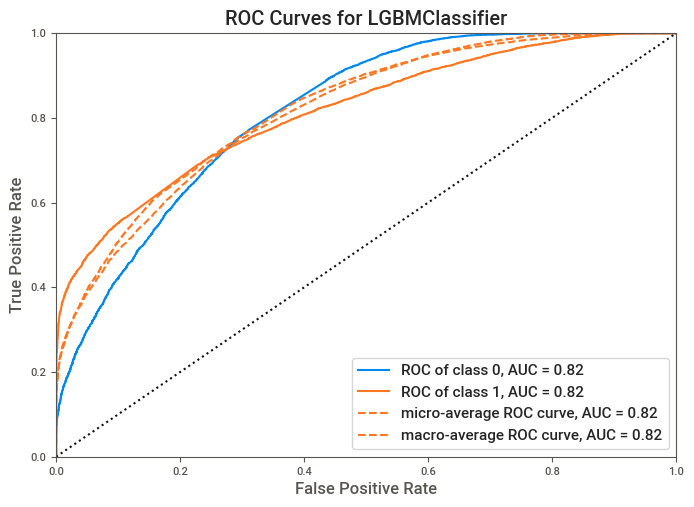

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6435,0.6644,0.2557,0.9498,0.4029,0.2540,0.3657
1,0.6478,0.6676,0.2660,0.9471,0.4154,0.2634,0.3727
Mean,0.6456,0.6660,0.2609,0.9485,0.4091,0.2587,0.3692
Std,0.0021,0.0016,0.0052,0.0014,0.0063,0.0047,0.0035


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 50069 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


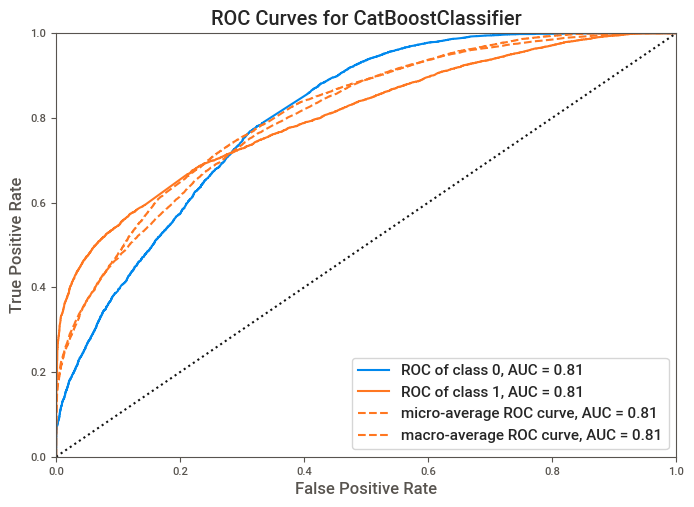

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4704,0.6433,1.0000,0.4704,0.6398,0.0000,0.0000
1,0.4704,0.6361,1.0000,0.4704,0.6398,0.0000,0.0000
Mean,0.4704,0.6397,1.0000,0.4704,0.6398,0.0000,0.0000
Std,0.0000,0.0036,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 50069 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


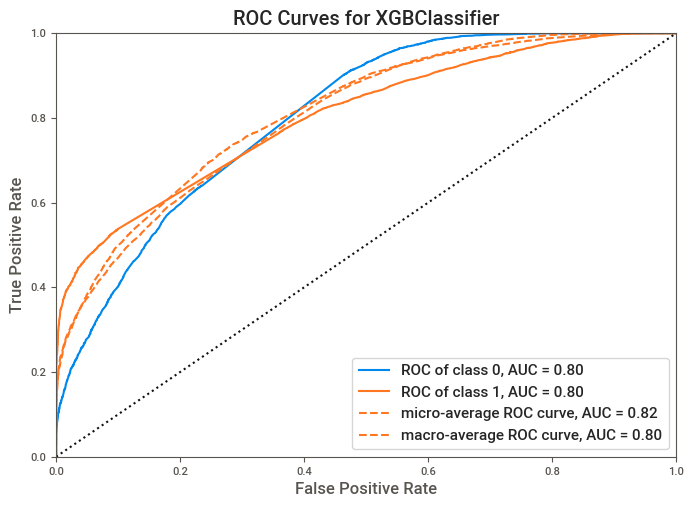

In [ ]:
#
# # Инициализация среды PyCaret с меньшей выборкой данных
# clf1 = setup(data=X_train_full_new.sample(frac=0.1), target='target', session_id=42, use_gpu=True)

# # Создание моделей для настройки
# lightgbm = create_model('lightgbm')
# catboost = create_model('catboost')
# xgboost = create_model('xgboost')

# models_to_tune = [lightgbm, catboost, xgboost]

# # Шаг 3: Тонкая настройка гиперпараметров для каждой модели
# tuned_models = []
# for model in models_to_tune:
#     # Настройка модели с оптимизацией по AUC
#     tuned = tune_model(
#         model,
#         optimize='AUC',  # Критерий оптимизации
#         n_iter=3,       # Уменьшаем количество итераций
#         fold=2,          # Уменьшаем количество фолдов
#         choose_better=True,  # Гарантирует улучшение метрик после настройки
#         search_library='optuna',
#         early_stopping='asha' # Используем early stopping
#     )
#     tuned_models.append(tuned)
#     # Визуализация ROC-кривой
#     plot_model(tuned, plot='auc')

In [ ]:
from pycaret.classification import *

# Инициализация среды PyCaret с меньшей выборкой данных
clf1 = setup(data=X_train_full_new.sample(frac=0.1), target='target', session_id=42, use_gpu=True, verbose=False)

# Создание моделей для настройки
lightgbm = create_model('lightgbm')
lightgbm_results = pull()
catboost = create_model('catboost')
catboost_results = pull()
xgboost = create_model('xgboost')
xgboost_results = pull()

# Создание ансамбля моделей
blender = blend_models(estimator_list=[lightgbm, catboost, xgboost], method='soft')
blender_results = pull()

# Создание таблицы для сравнения
comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'CatBoost', 'XGBoost', 'Blender'],
    'Accuracy': [lightgbm_results['Accuracy']['Mean'], catboost_results['Accuracy']['Mean'], xgboost_results['Accuracy']['Mean'], blender_results['Accuracy']['Mean']],
    'AUC': [lightgbm_results['AUC']['Mean'], catboost_results['AUC']['Mean'], xgboost_results['AUC']['Mean'], blender_results['AUC']['Mean']],
    'Recall': [lightgbm_results['Recall']['Mean'], catboost_results['Recall']['Mean'], xgboost_results['Recall']['Mean'], blender_results['Recall']['Mean']],
    'Prec.': [lightgbm_results['Prec.']['Mean'], catboost_results['Prec.']['Mean'], xgboost_results['Prec.']['Mean'], blender_results['Prec.']['Mean']],
    'F1': [lightgbm_results['F1']['Mean'], catboost_results['F1']['Mean'], xgboost_results['F1']['Mean'], blender_results['F1']['Mean']],
    'Kappa': [lightgbm_results['Kappa']['Mean'], catboost_results['Kappa']['Mean'], xgboost_results['Kappa']['Mean'], blender_results['Kappa']['Mean']],
    'MCC': [lightgbm_results['MCC']['Mean'], catboost_results['MCC']['Mean'], xgboost_results['MCC']['Mean'], blender_results['MCC']['Mean']]
})
comparison_df = comparison_df.set_index('Model')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7328,0.8207,0.5121,0.8667,0.6438,0.4517,0.4919
1,0.7250,0.8222,0.4900,0.8699,0.6269,0.4349,0.4800
2,0.7318,0.8250,0.5011,0.8776,0.6379,0.4491,0.4937
3,0.7342,0.8245,0.5015,0.8849,0.6402,0.4539,0.5001
4,0.7300,0.8216,0.5021,0.8700,0.6368,0.4455,0.4882
5,0.7378,0.8304,0.5102,0.8846,0.6471,0.4614,0.5059
6,0.7258,0.8113,0.4936,0.8675,0.6292,0.4366,0.4804
7,0.7294,0.8199,0.4924,0.8810,0.6317,0.4437,0.4908
8,0.7434,0.8247,0.5157,0.8955,0.6545,0.4729,0.5186


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7228,0.8065,0.4748,0.8834,0.6176,0.4296,0.4807
1,0.7238,0.8078,0.4756,0.8856,0.6189,0.4316,0.4831
2,0.7274,0.8159,0.4744,0.9003,0.6214,0.4387,0.4939
3,0.7268,0.8091,0.4803,0.8894,0.6238,0.4379,0.4893
4,0.7256,0.8052,0.4805,0.8846,0.6227,0.4354,0.4856
5,0.7338,0.8174,0.4898,0.8996,0.6343,0.4523,0.5041
6,0.7238,0.8002,0.4733,0.8886,0.6176,0.4313,0.4840
7,0.7236,0.8038,0.4699,0.8929,0.6158,0.4307,0.4851
8,0.7346,0.8148,0.4953,0.8944,0.6376,0.4542,0.5037


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7232,0.8057,0.4778,0.8806,0.6194,0.4305,0.4804
1,0.7260,0.8124,0.4740,0.8959,0.6199,0.4359,0.4901
2,0.7258,0.8152,0.4765,0.8914,0.6210,0.4356,0.4883
3,0.7330,0.8193,0.4909,0.8957,0.6342,0.4508,0.5016
4,0.7306,0.8119,0.4864,0.8934,0.6299,0.4457,0.4968
5,0.7304,0.8226,0.4826,0.8983,0.6279,0.4451,0.4981
6,0.7262,0.8023,0.4763,0.8928,0.6212,0.4363,0.4893
7,0.7294,0.8099,0.4822,0.8954,0.6268,0.4430,0.4954
8,0.7358,0.8186,0.4966,0.8967,0.6392,0.4567,0.5065


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7286,0.8194,0.4845,0.8896,0.6274,0.4417,0.4923
1,0.7248,0.8222,0.4752,0.8898,0.6195,0.4336,0.4861
2,0.7260,0.8269,0.4731,0.8972,0.6195,0.4358,0.4905
3,0.7306,0.8249,0.4862,0.8941,0.6299,0.4458,0.4971
4,0.7274,0.8213,0.4801,0.8914,0.6241,0.4389,0.4909
5,0.7336,0.8313,0.4881,0.9014,0.6333,0.4518,0.5044
6,0.7262,0.8121,0.4780,0.8903,0.6220,0.4364,0.4885
7,0.7274,0.8207,0.4737,0.9009,0.6209,0.4385,0.4940
8,0.7408,0.8262,0.5021,0.9060,0.6461,0.4669,0.5177


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

          Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Model                                                             
LightGBM    0.7321  0.8218  0.5022  0.8769  0.6387  0.4498  0.4940
CatBoost    0.7267  0.8080  0.4791  0.8906  0.6230  0.4375  0.4895
XGBoost     0.7289  0.8125  0.4824  0.8936  0.6265  0.4422  0.4941
Blender     0.7292  0.8222  0.4820  0.8954  0.6266  0.4428  0.4953


In [ ]:
print(comparison_df)

          Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Model                                                             
LightGBM    0.7321  0.8218  0.5022  0.8769  0.6387  0.4498  0.4940
CatBoost    0.7267  0.8080  0.4791  0.8906  0.6230  0.4375  0.4895
XGBoost     0.7289  0.8125  0.4824  0.8936  0.6265  0.4422  0.4941
Blender     0.7292  0.8222  0.4820  0.8954  0.6266  0.4428  0.4953


##Выводы по задаче классификации



В ходе работы  были выполнены следующие шаги:

*   **Загрузка и предобработка данных:** Данные были загружены из файлов Parquet, очищены от пропусков и дубликатов, а также были созданы новые текстовые признаки путем объединения столбцов 'name' и 'type'.
*   **Лемматизация:** Была применена лемматизация к текстовым данным для уменьшения количества уникальных слов и улучшения качества признаков. До лемматизции классификатор Catboost выдавал результат с ROC-AUC 78%, после - 80%
*   **Векторизация текста:** Был использован TF-IDF для преобразования текстовых данных в числовые признаки, которые могут быть использованы моделями машинного обучения.
*   **Сравнение моделей:** Был использован PyCaret для сравнения различных моделей машинного обучения и выбора лучших из них.
*   **Создание ансамбля:** Был создан ансамбль из трех лучших моделей (LightGBM, CatBoost и XGBoost) с использованием  голосования.

**Результаты:**

*   Лучшей моделью оказался ансамбль, который показал ROC AUC 0.8222. Это хороший результат, который говорит о том, что модель хорошо справляется с задачей классификации.

| Classifier | Accuracy | AUC    | Recall | Prec.  | F1     | Kappa  | MCC    |
|------------|----------|--------|--------|--------|--------|--------|--------|
| LightGBM   | 0.7321   | 0.8218 | 0.5022 | 0.8769 | 0.6387 | 0.4498 | 0.4940 |
| CatBoost   | 0.7266   | 0.8081 | 0.4790 | 0.8903 | 0.6229 | 0.4373 | 0.4891 |
| XGBoost    | 0.7289   | 0.8125 | 0.4824 | 0.8936 | 0.6265 | 0.4422 | 0.4941 |
| Blender    | 0.7292   | 0.8222 | 0.4820 | 0.8954 | 0.6266 | 0.4428 | 0.4953 |

**Рекомендации по улучшению:**

*   **Подбор гиперпараметров:** Можно попробовать улучшить производительность моделей, подобрав их гиперпараметры с помощью таких техник, как Grid Search или Randomized Search.
*   **Инженерия признаков:** Можно попробовать создать новые признаки из существующих данных, чтобы предоставить моделям больше информации. Например, можно извлечь длину названия продукта или количество слов в описании.
*   **Использование других моделей:** Можно попробовать использовать другие модели, такие как нейронные сети , чтобы увидеть, могут ли они дать лучшие результаты.
*   **Обработка изображений:** Можно попробовать извлечь признаки из изображений продуктов с помощью сверточных нейронных сетей (CNN) типа ResNet, EfficientNetи добавить их к существующим признакам.